In [1]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load your fraud dataset using pandas
data = pd.read_csv('year2013_2014_combined_with_labels.csv')

# Data preprocessing
data.fillna(0, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)

data['Rndrng_Prvdr_Type'] = data['Rndrng_Prvdr_Type'].astype('category').cat.codes
data['Rndrng_Prvdr_Gndr'] = data['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
data['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = data['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

X = data.drop('Fraud_Indicator', axis=1)  # Assuming 'fraud_label' is the name of the target variable
y = data['Fraud_Indicator']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to LightGBM's native dataset format
train_data = lgb.Dataset(X_train_scaled, label=y_train)

# Set hyperparameters for the LightGBM model
params = {
    'objective': 'binary',  # For binary classification tasks
    'metric': 'binary_logloss',  # Logarithmic loss for binary classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate for boosting
    'feature_fraction': 0.9,  # Fraction of features used per tree
    'bagging_fraction': 0.8,  # Fraction of data used for bagging
    'bagging_freq': 5,  # Frequency for bagging
    'verbose': -1,  # Set to 0 or 1 for more detailed output
    'seed': 42  # Seed for reproducibility
}



In [3]:
# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=100)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Convert probabilities to binary predictions (0 or 1) based on a threshold (e.g., 0.5)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
confusion_mat = confusion_matrix(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", report)

Accuracy: 0.9974966983480915
Confusion Matrix:
 [[368569    433]
 [   492     18]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    369002
           1       0.04      0.04      0.04       510

    accuracy                           1.00    369512
   macro avg       0.52      0.52      0.52    369512
weighted avg       1.00      1.00      1.00    369512



ROC-AUC: 0.7263886395854594


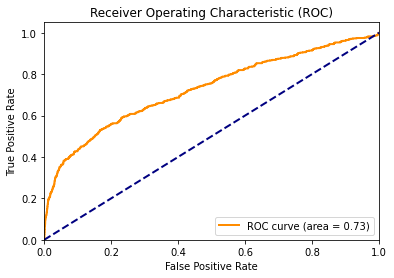

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, y_pred)

# Get ROC curve data
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_curve = auc(fpr, tpr)

# Print ROC-AUC score
print("ROC-AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [6]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 404 kB 8.7 MB/s eta 0:00:01     |████████████▏                   | 153 kB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 225 kB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.2 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
#Fine tune hyperparameters of light GBM model and re-run results with optimized model
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd


# Load your fraud dataset using pandas
data = pd.read_csv('year2013_2014_combined_with_labels.csv') 

# Data preprocessing
data.fillna(0, inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)

data['Rndrng_Prvdr_Type'] = data['Rndrng_Prvdr_Type'].astype('category').cat.codes
data['Rndrng_Prvdr_Gndr'] = data['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
data['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = data['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

fraud_data = data

# Assume that 'fraud_indicator' is the column containing the target variable
X = fraud_data.drop('Fraud_Indicator', axis=1)
y = fraud_data['Fraud_Indicator']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    model = lgb.LGBMClassifier(**params)
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    # Train the model
    num_round = 1000  # Set a sufficiently large number of rounds
    early_stopping_rounds = 10

    model = lgb.train(params, train_data, num_boost_round=num_round,
                      valid_sets=[valid_data])

    y_pred = model.predict(X_valid)
    auc = roc_auc_score(y_valid, y_pred)
    return auc

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: {}'.format(trial.value))
print('Params: ')
for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

[I 2023-08-08 17:41:53,512] A new study created in memory with name: no-name-694c988d-a658-45d6-a3c3-f8012e1d5146
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.056627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:43:34,526] Trial 0 finished with value: 0.6485452786216899 and parameters: {'num_leaves': 36, 'learning_rate': 0.06713027952811859, 'n_estimators': 297, 'colsample_bytree': 0.9338203144778859}. Best is trial 0 with value: 0.6485452786216899.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.019625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:45:00,717] Trial 1 finished with value: 0.8456224638136293 and parameters: {'num_leaves': 29, 'learning_rate': 0.02985062265004258, 'n_estimators': 208, 'colsample_bytree': 0.7531698189095689}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.914641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:46:11,436] Trial 2 finished with value: 0.7876411850044704 and parameters: {'num_leaves': 27, 'learning_rate': 0.04623622630126553, 'n_estimators': 211, 'colsample_bytree': 0.5395007766259353}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:46:59,832] Trial 3 finished with value: 0.7543837771855426 and parameters: {'num_leaves': 15, 'learning_rate': 0.0888450945140523, 'n_estimators': 151, 'colsample_bytree': 0.8091194231899981}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.923052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:47:48,090] Trial 4 finished with value: 0.6566286903594019 and parameters: {'num_leaves': 33, 'learning_rate': 0.09218479937253352, 'n_estimators': 163, 'colsample_bytree': 0.5338906404310262}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.049519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:49:47,782] Trial 5 finished with value: 0.830925691884767 and parameters: {'num_leaves': 27, 'learning_rate': 0.035883326931722685, 'n_estimators': 294, 'colsample_bytree': 0.8509031172534143}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.019010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:50:18,649] Trial 6 finished with value: 0.7694016058789628 and parameters: {'num_leaves': 49, 'learning_rate': 0.0017133565572966278, 'n_estimators': 59, 'colsample_bytree': 0.7538322755580567}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.008802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:50:52,675] Trial 7 finished with value: 0.8083674954309722 and parameters: {'num_leaves': 20, 'learning_rate': 0.012707611904063582, 'n_estimators': 65, 'colsample_bytree': 0.7630044450670367}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.048107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:52:03,346] Trial 8 finished with value: 0.8303233756849822 and parameters: {'num_leaves': 3, 'learning_rate': 0.09428351130549095, 'n_estimators': 230, 'colsample_bytree': 0.9717719516484934}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.016977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:52:54,947] Trial 9 finished with value: 0.651555323946913 and parameters: {'num_leaves': 39, 'learning_rate': 0.09075498961200457, 'n_estimators': 134, 'colsample_bytree': 0.936897145111285}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.992346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:54:08,073] Trial 10 finished with value: 0.8369856330020423 and parameters: {'num_leaves': 10, 'learning_rate': 0.03390728001812163, 'n_estimators': 228, 'colsample_bytree': 0.654995287087722}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.985391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:55:24,163] Trial 11 finished with value: 0.8365400857065337 and parameters: {'num_leaves': 7, 'learning_rate': 0.02721584930451043, 'n_estimators': 235, 'colsample_bytree': 0.6698524938115817}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.988312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:56:35,308] Trial 12 finished with value: 0.8415953216046121 and parameters: {'num_leaves': 14, 'learning_rate': 0.02623231768754375, 'n_estimators': 200, 'colsample_bytree': 0.6677830725797439}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.989941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:57:22,308] Trial 13 finished with value: 0.8309399194499292 and parameters: {'num_leaves': 19, 'learning_rate': 0.020509741222511632, 'n_estimators': 107, 'colsample_bytree': 0.6702358917498625}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 17:58:32,741] Trial 14 finished with value: 0.8171642036904843 and parameters: {'num_leaves': 15, 'learning_rate': 0.04890650322786932, 'n_estimators': 196, 'colsample_bytree': 0.7038515617326513}. Best is trial 1 with value: 0.8456224638136293.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.966448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:00:14,802] Trial 15 finished with value: 0.8595689103550211 and parameters: {'num_leaves': 44, 'learning_rate': 0.01656567412161762, 'n_estimators': 258, 'colsample_bytree': 0.6044963551068188}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.980391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:02:03,461] Trial 16 finished with value: 0.8565456630183523 and parameters: {'num_leaves': 50, 'learning_rate': 0.014297571582699618, 'n_estimators': 257, 'colsample_bytree': 0.5881802191382521}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.992349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:03:31,347] Trial 17 finished with value: 0.8009321539359318 and parameters: {'num_leaves': 46, 'learning_rate': 0.0011928844893127292, 'n_estimators': 267, 'colsample_bytree': 0.5821178911541245}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.976363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:05:16,110] Trial 18 finished with value: 0.8550269375233739 and parameters: {'num_leaves': 43, 'learning_rate': 0.014643489787431406, 'n_estimators': 256, 'colsample_bytree': 0.5936778793307118}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.885983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:06:54,667] Trial 19 finished with value: 0.8564137412082681 and parameters: {'num_leaves': 50, 'learning_rate': 0.01331446176132904, 'n_estimators': 265, 'colsample_bytree': 0.5026386310222658}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:08:45,873] Trial 20 finished with value: 0.8473154085673164 and parameters: {'num_leaves': 42, 'learning_rate': 0.008644131786648055, 'n_estimators': 276, 'colsample_bytree': 0.6068632397342726}. Best is trial 15 with value: 0.8595689103550211.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.882554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:10:19,178] Trial 21 finished with value: 0.8623002362174349 and parameters: {'num_leaves': 50, 'learning_rate': 0.021190933401402153, 'n_estimators': 252, 'colsample_bytree': 0.5008522679400409}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.914706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:11:51,903] Trial 22 finished with value: 0.8554647453422592 and parameters: {'num_leaves': 45, 'learning_rate': 0.020068609786636594, 'n_estimators': 245, 'colsample_bytree': 0.5126546158142194}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.892155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:13:05,901] Trial 23 finished with value: 0.8319844645084553 and parameters: {'num_leaves': 50, 'learning_rate': 0.038879019028871475, 'n_estimators': 179, 'colsample_bytree': 0.5687989351588159}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.974148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:14:56,666] Trial 24 finished with value: 0.8615372083110022 and parameters: {'num_leaves': 39, 'learning_rate': 0.02069715862555879, 'n_estimators': 281, 'colsample_bytree': 0.6204508983624217}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.977781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:16:42,799] Trial 25 finished with value: 0.8539854824103722 and parameters: {'num_leaves': 39, 'learning_rate': 0.022977580249464342, 'n_estimators': 280, 'colsample_bytree': 0.6314993997820141}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.907027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:18:27,517] Trial 26 finished with value: 0.8287268834612832 and parameters: {'num_leaves': 33, 'learning_rate': 0.04110329198066197, 'n_estimators': 299, 'colsample_bytree': 0.5605985629284025}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.877337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:19:54,377] Trial 27 finished with value: 0.8537583514877597 and parameters: {'num_leaves': 40, 'learning_rate': 0.029138750314414277, 'n_estimators': 249, 'colsample_bytree': 0.5016355203928742}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.008877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:21:49,089] Trial 28 finished with value: 0.8432903094951077 and parameters: {'num_leaves': 46, 'learning_rate': 0.006915583948625599, 'n_estimators': 283, 'colsample_bytree': 0.6208903142697614}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.912608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:22:53,522] Trial 29 finished with value: 0.653129498421338 and parameters: {'num_leaves': 34, 'learning_rate': 0.06407189025082602, 'n_estimators': 230, 'colsample_bytree': 0.5546644634009241}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.909363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:24:07,697] Trial 30 finished with value: 0.8527230337558084 and parameters: {'num_leaves': 43, 'learning_rate': 0.022455685594189048, 'n_estimators': 181, 'colsample_bytree': 0.5380301152859722}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.986101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:25:50,632] Trial 31 finished with value: 0.8571388183134349 and parameters: {'num_leaves': 47, 'learning_rate': 0.016422008777261417, 'n_estimators': 259, 'colsample_bytree': 0.5933321092648749}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.994937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:27:41,479] Trial 32 finished with value: 0.8551851597382276 and parameters: {'num_leaves': 38, 'learning_rate': 0.018642703926426203, 'n_estimators': 284, 'colsample_bytree': 0.6127813823253752}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.906624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:29:13,712] Trial 33 finished with value: 0.8457819055340685 and parameters: {'num_leaves': 46, 'learning_rate': 0.033743260946792086, 'n_estimators': 244, 'colsample_bytree': 0.5700945189600529}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.917990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:30:35,965] Trial 34 finished with value: 0.8509788671106624 and parameters: {'num_leaves': 36, 'learning_rate': 0.02976065344162704, 'n_estimators': 220, 'colsample_bytree': 0.5335840999103951}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.987002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:32:22,749] Trial 35 finished with value: 0.8404127625218248 and parameters: {'num_leaves': 30, 'learning_rate': 0.008311286971754166, 'n_estimators': 266, 'colsample_bytree': 0.7019031980496792}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.012343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:33:57,642] Trial 36 finished with value: 0.81767194842772 and parameters: {'num_leaves': 47, 'learning_rate': 0.04325042386539345, 'n_estimators': 216, 'colsample_bytree': 0.6318832309873927}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.900988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:35:41,128] Trial 37 finished with value: 0.8534405148555972 and parameters: {'num_leaves': 42, 'learning_rate': 0.024368099589267837, 'n_estimators': 295, 'colsample_bytree': 0.5327235775023931}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:37:04,232] Trial 38 finished with value: 0.8521623454721698 and parameters: {'num_leaves': 36, 'learning_rate': 0.01776900515053776, 'n_estimators': 205, 'colsample_bytree': 0.5928357250494033}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.905046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:38:32,693] Trial 39 finished with value: 0.8360579718415895 and parameters: {'num_leaves': 24, 'learning_rate': 0.0337078045160047, 'n_estimators': 271, 'colsample_bytree': 0.5514241877374105}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.005741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:40:23,479] Trial 40 finished with value: 0.837335495604413 and parameters: {'num_leaves': 30, 'learning_rate': 0.006739357682220202, 'n_estimators': 288, 'colsample_bytree': 0.6386868720968664}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.987809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:42:06,739] Trial 41 finished with value: 0.8576955159709534 and parameters: {'num_leaves': 49, 'learning_rate': 0.017092151386521152, 'n_estimators': 256, 'colsample_bytree': 0.5866593516390942}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.999556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:43:52,402] Trial 42 finished with value: 0.8579429507316555 and parameters: {'num_leaves': 48, 'learning_rate': 0.016615557287284262, 'n_estimators': 256, 'colsample_bytree': 0.6001006797398095}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.911053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:45:23,797] Trial 43 finished with value: 0.8534401641481087 and parameters: {'num_leaves': 44, 'learning_rate': 0.024762714607757627, 'n_estimators': 241, 'colsample_bytree': 0.5704927300171281}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.920002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:47:00,001] Trial 44 finished with value: 0.8505476589690624 and parameters: {'num_leaves': 41, 'learning_rate': 0.012909049304887968, 'n_estimators': 251, 'colsample_bytree': 0.5294300858789412}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.989824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:47:58,551] Trial 45 finished with value: 0.8457265761139932 and parameters: {'num_leaves': 48, 'learning_rate': 0.019328232491719298, 'n_estimators': 126, 'colsample_bytree': 0.6109304774543305}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.998186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:49:36,369] Trial 46 finished with value: 0.8446536875138888 and parameters: {'num_leaves': 44, 'learning_rate': 0.009200674326694868, 'n_estimators': 227, 'colsample_bytree': 0.6432077691889827}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.895058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:50:42,181] Trial 47 finished with value: 0.8534120783233972 and parameters: {'num_leaves': 48, 'learning_rate': 0.028557897416109916, 'n_estimators': 163, 'colsample_bytree': 0.5208300920865486}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.908881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:51:20,244] Trial 48 finished with value: 0.8368392099686798 and parameters: {'num_leaves': 48, 'learning_rate': 0.024078911559414294, 'n_estimators': 74, 'colsample_bytree': 0.5543692025750353}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.000008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:52:53,092] Trial 49 finished with value: 0.8238759187340609 and parameters: {'num_leaves': 38, 'learning_rate': 0.004001450778590328, 'n_estimators': 235, 'colsample_bytree': 0.652844516427257}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.973575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:54:12,535] Trial 50 finished with value: 0.8471554328150196 and parameters: {'num_leaves': 50, 'learning_rate': 0.012964864567764182, 'n_estimators': 191, 'colsample_bytree': 0.5759199479820727}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.044426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:55:59,047] Trial 51 finished with value: 0.8587312375478914 and parameters: {'num_leaves': 46, 'learning_rate': 0.017847710694220247, 'n_estimators': 260, 'colsample_bytree': 0.5988926071502877}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.985499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:57:45,977] Trial 52 finished with value: 0.8571028256289807 and parameters: {'num_leaves': 45, 'learning_rate': 0.02098907110195837, 'n_estimators': 273, 'colsample_bytree': 0.6085938447454717}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.917182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 18:59:29,720] Trial 53 finished with value: 0.8581028388070802 and parameters: {'num_leaves': 48, 'learning_rate': 0.016513194581136252, 'n_estimators': 260, 'colsample_bytree': 0.5486558576355811}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.882673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:01:06,586] Trial 54 finished with value: 0.8486911809075693 and parameters: {'num_leaves': 41, 'learning_rate': 0.00981251097198562, 'n_estimators': 266, 'colsample_bytree': 0.523167659802586}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.881035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:02:52,982] Trial 55 finished with value: 0.8295979903823253 and parameters: {'num_leaves': 44, 'learning_rate': 0.003382656590434633, 'n_estimators': 290, 'colsample_bytree': 0.5564151081222276}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.890801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:04:27,727] Trial 56 finished with value: 0.842359874557245 and parameters: {'num_leaves': 24, 'learning_rate': 0.011768077286931735, 'n_estimators': 279, 'colsample_bytree': 0.5489162919949562}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.879458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:06:00,009] Trial 57 finished with value: 0.8586598499758382 and parameters: {'num_leaves': 47, 'learning_rate': 0.026436153550762526, 'n_estimators': 238, 'colsample_bytree': 0.5030158653510468}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.896171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:07:27,601] Trial 58 finished with value: 0.8572418492657088 and parameters: {'num_leaves': 46, 'learning_rate': 0.026243140421959167, 'n_estimators': 240, 'colsample_bytree': 0.5012438044765855}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.880268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:08:49,760] Trial 59 finished with value: 0.8542404254995801 and parameters: {'num_leaves': 42, 'learning_rate': 0.03152434013403494, 'n_estimators': 218, 'colsample_bytree': 0.5103097345223474}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.909954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:10:35,265] Trial 60 finished with value: 0.8592570144951656 and parameters: {'num_leaves': 50, 'learning_rate': 0.014911249559899229, 'n_estimators': 275, 'colsample_bytree': 0.5193578359982282}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.884546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:12:18,528] Trial 61 finished with value: 0.8596310599729999 and parameters: {'num_leaves': 50, 'learning_rate': 0.020001247647388216, 'n_estimators': 263, 'colsample_bytree': 0.5209627051196865}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.893982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:14:01,217] Trial 62 finished with value: 0.860452945629393 and parameters: {'num_leaves': 50, 'learning_rate': 0.021318288654302287, 'n_estimators': 275, 'colsample_bytree': 0.5178378532225968}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.886793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:15:47,792] Trial 63 finished with value: 0.8608022821705308 and parameters: {'num_leaves': 50, 'learning_rate': 0.02122630399212637, 'n_estimators': 273, 'colsample_bytree': 0.5203228791919616}. Best is trial 21 with value: 0.8623002362174349.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.883283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:17:37,872] Trial 64 finished with value: 0.862648358566737 and parameters: {'num_leaves': 50, 'learning_rate': 0.02180908857341951, 'n_estimators': 300, 'colsample_bytree': 0.5194728939565287}. Best is trial 64 with value: 0.862648358566737.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.936787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:19:27,610] Trial 65 finished with value: 0.8572811285044313 and parameters: {'num_leaves': 49, 'learning_rate': 0.030071203936303262, 'n_estimators': 300, 'colsample_bytree': 0.5410038493231791}. Best is trial 64 with value: 0.862648358566737.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.884695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:21:16,070] Trial 66 finished with value: 0.8639535935349094 and parameters: {'num_leaves': 50, 'learning_rate': 0.021369750690317827, 'n_estimators': 285, 'colsample_bytree': 0.5219915124222101}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.912501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:23:02,535] Trial 67 finished with value: 0.8630740297810171 and parameters: {'num_leaves': 50, 'learning_rate': 0.022447293647308932, 'n_estimators': 290, 'colsample_bytree': 0.518134667312801}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.898132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:24:56,686] Trial 68 finished with value: 0.8417555683581501 and parameters: {'num_leaves': 50, 'learning_rate': 0.03713356542065814, 'n_estimators': 293, 'colsample_bytree': 0.5348997466236617}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.895355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:26:40,278] Trial 69 finished with value: 0.8607866039516657 and parameters: {'num_leaves': 47, 'learning_rate': 0.022481935211569517, 'n_estimators': 286, 'colsample_bytree': 0.5195071958098472}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:28:24,385] Trial 70 finished with value: 0.8471362661193929 and parameters: {'num_leaves': 11, 'learning_rate': 0.022861099959275294, 'n_estimators': 286, 'colsample_bytree': 0.5631285636109539}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.876792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:30:05,502] Trial 71 finished with value: 0.858093223576768 and parameters: {'num_leaves': 45, 'learning_rate': 0.021001979030298747, 'n_estimators': 282, 'colsample_bytree': 0.513664709112832}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.938207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:31:06,458] Trial 72 finished with value: 0.7873893345176619 and parameters: {'num_leaves': 2, 'learning_rate': 0.03202287632564707, 'n_estimators': 300, 'colsample_bytree': 0.5328842327065506}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.879242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:32:42,612] Trial 73 finished with value: 0.8563864205635316 and parameters: {'num_leaves': 47, 'learning_rate': 0.02823350872765002, 'n_estimators': 273, 'colsample_bytree': 0.5013548073061559}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.875158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:34:33,004] Trial 74 finished with value: 0.8631988550782073 and parameters: {'num_leaves': 49, 'learning_rate': 0.02637676028258595, 'n_estimators': 291, 'colsample_bytree': 0.5129398959999374}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.931398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:36:19,497] Trial 75 finished with value: 0.8621026125476126 and parameters: {'num_leaves': 49, 'learning_rate': 0.02606109006203486, 'n_estimators': 293, 'colsample_bytree': 0.5452045663397366}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.973412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:38:13,818] Trial 76 finished with value: 0.8585830716045855 and parameters: {'num_leaves': 49, 'learning_rate': 0.02608681071119185, 'n_estimators': 294, 'colsample_bytree': 0.5764883218979979}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.902840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:39:59,018] Trial 77 finished with value: 0.8399906329218046 and parameters: {'num_leaves': 43, 'learning_rate': 0.03728621465899859, 'n_estimators': 291, 'colsample_bytree': 0.5403134723330405}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.915141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:41:44,260] Trial 78 finished with value: 0.8489252515874562 and parameters: {'num_leaves': 45, 'learning_rate': 0.03472720935002288, 'n_estimators': 281, 'colsample_bytree': 0.5451231680378187}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.910524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:43:15,118] Trial 79 finished with value: 0.8493192501958915 and parameters: {'num_leaves': 19, 'learning_rate': 0.027821117231110935, 'n_estimators': 290, 'colsample_bytree': 0.5695214471579542}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.917923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:44:58,122] Trial 80 finished with value: 0.861066441958814 and parameters: {'num_leaves': 49, 'learning_rate': 0.024918531766754924, 'n_estimators': 269, 'colsample_bytree': 0.5334390475932836}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.899226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:46:37,889] Trial 81 finished with value: 0.8621761654727202 and parameters: {'num_leaves': 49, 'learning_rate': 0.024426374371304002, 'n_estimators': 268, 'colsample_bytree': 0.5312478064878791}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.911564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:48:19,015] Trial 82 finished with value: 0.8619961568835749 and parameters: {'num_leaves': 48, 'learning_rate': 0.025523721439738127, 'n_estimators': 268, 'colsample_bytree': 0.5368211952845365}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.888953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:49:56,695] Trial 83 finished with value: 0.8595898784118392 and parameters: {'num_leaves': 48, 'learning_rate': 0.02345538338871628, 'n_estimators': 251, 'colsample_bytree': 0.5597841533258956}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.895618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:51:39,722] Trial 84 finished with value: 0.8599777290117244 and parameters: {'num_leaves': 46, 'learning_rate': 0.029630435350484395, 'n_estimators': 295, 'colsample_bytree': 0.5086895782997092}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.903327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:53:27,345] Trial 85 finished with value: 0.859700170603252 and parameters: {'num_leaves': 48, 'learning_rate': 0.018928967135765182, 'n_estimators': 280, 'colsample_bytree': 0.5470650646620112}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:55:13,249] Trial 86 finished with value: 0.8573079204310599 and parameters: {'num_leaves': 47, 'learning_rate': 0.03193823645129462, 'n_estimators': 284, 'colsample_bytree': 0.5843358107659409}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.885762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:56:53,786] Trial 87 finished with value: 0.8540447094659458 and parameters: {'num_leaves': 44, 'learning_rate': 0.024421389278610782, 'n_estimators': 267, 'colsample_bytree': 0.5327121657238066}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.920226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 19:58:49,353] Trial 88 finished with value: 0.8571133255986392 and parameters: {'num_leaves': 49, 'learning_rate': 0.014056868562128656, 'n_estimators': 298, 'colsample_bytree': 0.5643018521050744}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.873402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:00:37,120] Trial 89 finished with value: 0.8603142381607793 and parameters: {'num_leaves': 43, 'learning_rate': 0.015746848764460537, 'n_estimators': 288, 'colsample_bytree': 0.5007921785379891}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.874709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:02:07,494] Trial 90 finished with value: 0.8586432205957543 and parameters: {'num_leaves': 45, 'learning_rate': 0.027341640097247488, 'n_estimators': 250, 'colsample_bytree': 0.526282715118696}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.875292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:03:53,999] Trial 91 finished with value: 0.8611725097191141 and parameters: {'num_leaves': 49, 'learning_rate': 0.01880809128161601, 'n_estimators': 269, 'colsample_bytree': 0.5387144450036613}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.899703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:05:38,956] Trial 92 finished with value: 0.8604977166285617 and parameters: {'num_leaves': 49, 'learning_rate': 0.018269989221036204, 'n_estimators': 277, 'colsample_bytree': 0.5432386595177139}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.889884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:07:25,784] Trial 93 finished with value: 0.8585688998337965 and parameters: {'num_leaves': 46, 'learning_rate': 0.019830227257780973, 'n_estimators': 270, 'colsample_bytree': 0.5573023634296266}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.879338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:09:01,125] Trial 94 finished with value: 0.8591590873996008 and parameters: {'num_leaves': 48, 'learning_rate': 0.024364012490043045, 'n_estimators': 262, 'colsample_bytree': 0.5133477313550248}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.987181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:10:59,920] Trial 95 finished with value: 0.858770391913493 and parameters: {'num_leaves': 47, 'learning_rate': 0.011704693039171966, 'n_estimators': 294, 'colsample_bytree': 0.5767265660454309}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.897801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:11:44,044] Trial 96 finished with value: 0.8387523591720796 and parameters: {'num_leaves': 49, 'learning_rate': 0.02231203932805184, 'n_estimators': 93, 'colsample_bytree': 0.5270404989709546}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.897665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:13:27,074] Trial 97 finished with value: 0.8544401985812076 and parameters: {'num_leaves': 34, 'learning_rate': 0.015267219510530998, 'n_estimators': 281, 'colsample_bytree': 0.5496626222095871}. Best is trial 66 with value: 0.8639535935349094.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.897910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:15:09,129] Trial 98 finished with value: 0.8650146165316496 and parameters: {'num_leaves': 50, 'learning_rate': 0.02749228980939882, 'n_estimators': 287, 'colsample_bytree': 0.5106832340907823}. Best is trial 98 with value: 0.8650146165316496.
/home/dubeyr/.local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.898219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066


[I 2023-08-08 20:16:56,526] Trial 99 finished with value: 0.8579669901358735 and parameters: {'num_leaves': 50, 'learning_rate': 0.030263412148114014, 'n_estimators': 288, 'colsample_bytree': 0.5097892086403123}. Best is trial 98 with value: 0.8650146165316496.


Number of finished trials: 100
Best trial:
Value: 0.8650146165316496
Params: 
num_leaves: 50
learning_rate: 0.02749228980939882
n_estimators: 287
colsample_bytree: 0.5106832340907823


In [15]:
best_params = study.best_trial.params

# Train the LightGBM model with the best trial parameters on the entire training dataset
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the model on the test dataset
y_test_pred = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred)

print('Test AUC:', test_auc)

[LightGBM] [Info] Number of positive: 2030, number of negative: 1476016
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.873050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18251
[LightGBM] [Info] Number of data points in the train set: 1478046, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001373 -> initscore=-6.589066
[LightGBM] [Info] Start training from score -6.589066
Test AUC: 0.8650146165316496


ROC-AUC: 0.8650146165316496


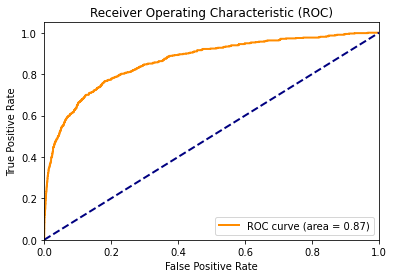

In [17]:
roc_auc = roc_auc_score(y_test, y_test_pred)

# Get ROC curve data of optimized model
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc_curve = auc(fpr, tpr)

# Print ROC-AUC score of optimized model
print("ROC-AUC:", roc_auc)

# Plot ROC curve of optimized model
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

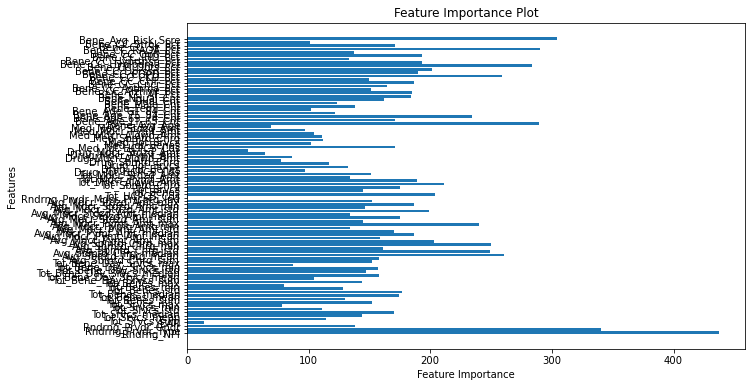

In [18]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importance = best_model.feature_importances_

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

In [21]:
pip install pdpbox

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 35.8 MB 21.8 MB/s eta 0:00:01   |▌                               | 563 kB 4.2 MB/s eta 0:00:09     |███▌                            | 4.0 MB 1.3 MB/s eta 0:00:26     |████████▏                       | 9.1 MB 2.2 MB/s eta 0:00:13     |██████████▌                     | 11.7 MB 2.2 MB/s eta 0:00:11     |████████████████████▌           | 22.9 MB 13.2 MB/s eta 0:00:01     |█████████████████████████████   | 32.5 MB 21.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 24.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 24.8 MB/s eta 0:00:01    |██████▏                         | 2.2 MB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 18.3 MB 68.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 40.8 MB/s eta 0:00:01
     |██████████████████████████

In [25]:
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt

# Specify the feature for which you want to create the partial dependence plot
feature_name = 'Rndrng_Prvdr_Type'

# Create a partial dependence plot for a single feature
pdp_feature = pdp.pdp_plot(
    model=best_model,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature_name
)
plt.title('Partial Dependence Plot')
plt.show()

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_plot'

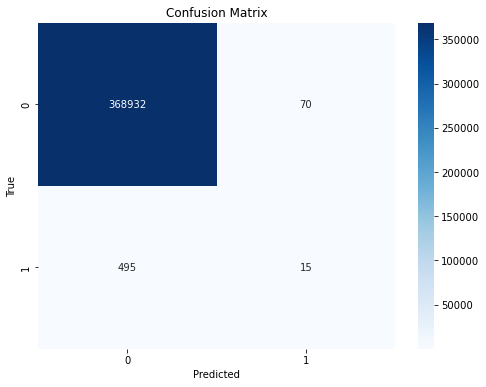

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred > 0.5)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()